In [3]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# os.chdir('/home/ubuntu/kaggle_salt_challenge')

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers


import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

import warnings
warnings.filterwarnings(action='once')

# import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))
import sys
from sklearn.model_selection import train_test_split
from keras.models import load_model, save_model
from keras.optimizers import Adam, Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print("Imports successfull")
import matplotlib
# matplotlib.use('GTKAgg')
matplotlib.use('Qt5Agg')
t_start = time.time()

print(os.getcwd())
# sys.path.append('/home/ubuntu/kaggle_salt_challenge')
from data_loader import DataLoader

ims = DataLoader


img_size_ori = 101

from metrics import my_iou_metric, my_iou_metric_2
from losses import lovasz_loss
from data_loader import DataLoader
import albumentations
import time

from tqdm import tqdm
import utils

from utils import plot_imgs, plot_pictures_pairs_example

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img


Imports successfull
/home/dzvinka/PycharmProjects/kaggle_salt_challenge


/home/dzvinka/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Data analysis

In [4]:

best_theshhold = 0

conf_path = 'configs.txt'
#read configs
# if len(sys.argv) < 2:
#     raise RuntimeError('No config file provided')
# conf_path = sys.argv[1]
with open(conf_path) as file:
    configs = {l.split('=')[0]: l.split('=')[1].strip() for l in file.readlines()}

configs['augmentations'] = configs['augmentations'].split(',')


In [6]:

st = time.time()

# ============================= INIT
train_dl = DataLoader(csv_file='data/train/train.csv', root_dir='data/train/')
train_df = pd.read_csv("data/train/train.csv", index_col="id", usecols=[0])
# ============================= DATA LOAD
data = [
    [train_dl[i]['img'], train_dl[i]['mask']]
    for i in tqdm(range(len(train_df)))
]
depths_df = pd.read_csv("data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

train_df["images"] = [s[0] for s in data]
train_df["masks"] = [s[1] for s in data]


100%|██████████| 4000/4000 [00:12<00:00, 320.78it/s]


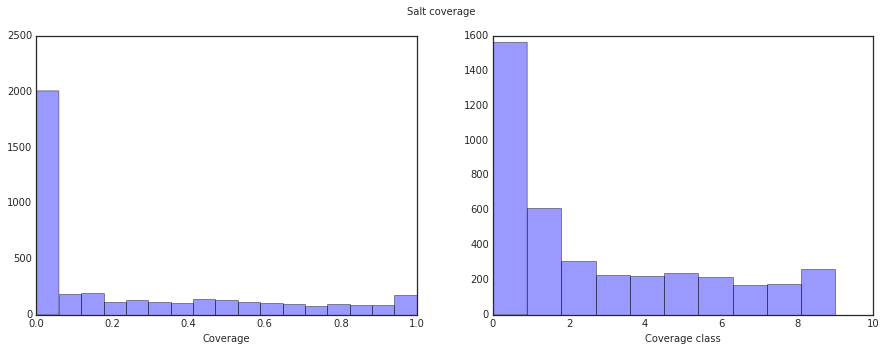

In [4]:

t = time.time() - st
# print(f'data loading time [ {t} ] ')

# ============================== Splitting to salt-coverage classes
train_df["coverage"] = train_df.masks.map(np.sum) / pow(int(configs['input_size']), 2)
"""pixels with ones divided on number of all pixels (presumed squares)"""


N_COVERAGE_CLASSES = 10


def cov_to_class(val):
    for i in range(N_COVERAGE_CLASSES):
        if val * (N_COVERAGE_CLASSES - 1) <= i:
            return i


train_df["coverage_class"] = train_df.coverage.map(cov_to_class)
# print(train_df)


fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
# plt.show()


ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = \
train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, int(configs['output_size']), int(configs['output_size']), 1),
    np.array(train_df.masks.tolist()).reshape(-1, int(configs['output_size']), int(configs['output_size']), 1),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1234)


## Prediction

In [8]:

model = load_model('baseline_add_training_process5.model', custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                               'lovasz_loss': lovasz_loss})
print("MODEL IS LOADED")

def predict_result(model, x_test, img_size_target): # predict both orginal and reflect x
    x_test_reflect = np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2



def plot_prediciton_and_error(img, mask, predict, max_images=60, grid_width=15, img_size_ori=101):
    grid_height = int(max_images / grid_width)
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
    for i, idx in enumerate(train_df.index[:max_images]):
        img = train_df.loc[idx].images
        mask = train_df.loc[idx].masks
        #TODO add here predictions
        ax = axs[int(i / grid_width), i % grid_width]
        ax.imshow(img, cmap="Greys")
        ax.imshow(mask, alpha=0.3, cmap="Greens")
        ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
        ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
        ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.suptitle("Green: predict. RED: Truth Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
    plt.show()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(101, 101)


In [9]:
preds_train_example = predict_result(model, x_train[:10], int(configs['output_size']))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(101, 101)


In [10]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = \
train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, int(configs['output_size']), int(configs['output_size']), 1),
    np.array(train_df.masks.tolist()).reshape(-1, int(configs['output_size']), int(configs['output_size']), 1),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.0, 
    shuffle=False,
    #stratify=train_df.coverage_class,
    random_state=1234)
len(x_train)

4000

In [11]:

preds_train_full = predict_result(model, x_train, int(configs['output_size']))
print(train_df.keys())
# train_df = train_df.join(preds_train_full)


Index(['z', 'images', 'masks', 'coverage', 'coverage_class', 'predict'], dtype='object')
merged
<class 'numpy.ndarray'>
(101, 101)
<class 'numpy.ndarray'>
(101, 101)


In [15]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,5
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,9
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


In [84]:
# print(list(preds_train_full))
preds_full_df = pd.Series(
    [np.array(np.round(single_pred > best_theshhold), dtype=np.float64)
        for single_pred in list(preds_train_full)
     ],
    index=train_df.index
)

In [85]:
train_df['predict'] = preds_full_df
print(train_df.keys())
print('merged')
print(type(train_df['predict'][0]))
print(train_df['predict'][0].shape)
print(type(train_df['masks'][0]))
print(train_df['predict'][0].shape)

Index(['z', 'images', 'masks', 'coverage', 'coverage_class', 'predict',
       'false_positives', 'sort_val'],
      dtype='object')
merged
<class 'numpy.ndarray'>
(101, 101)
<class 'numpy.ndarray'>
(101, 101)


## Error analysis

In [87]:
def plot_prediciton_and_error(train_df, max_images=100, grid_width=10, img_size_ori=101):
    grid_height = int(max_images / grid_width)
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
    for i, idx in enumerate(train_df.index[:max_images]):
        img = train_df.loc[idx].images
        mask = train_df.loc[idx].masks
        pred = np.array(train_df.loc[idx].predict, dtype=np.float64)
        # print(img.dtype)
        # print(mask.dtype)
        # print(pred.dtype)
        # break
        ax = axs[int(i / grid_width), i % grid_width]
        ax.imshow(img, cmap="Greys")
        ax.imshow(mask, alpha=0.4, cmap="Greens")
        ax.imshow(pred, alpha=0.3, cmap="Reds")
        ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
        ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
        ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
    plt.show()

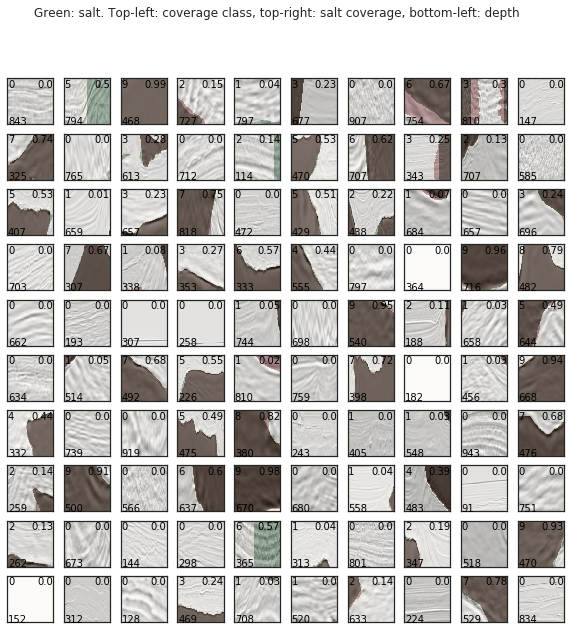

In [88]:
plot_prediciton_and_error(train_df)

In [95]:

false_positives = [
    np.array(np.round((row['predict'] - row['masks']) > 0), dtype=np.float64)
    for index, row in train_df.iterrows()
]
false_negatives = [
    np.array(np.round((row['masks'] - row['predict']) > 0), dtype=np.float64)
    for index, row in train_df.iterrows()
]

In [96]:
train_df['false_positives'] = pd.Series(false_positives, index=train_df.index)
train_df['false_negatives'] = pd.Series(false_negatives, index=train_df.index)

In [97]:
def plot_prediciton_and_false_positive(train_df, max_images=100, grid_width=10, img_size_ori=101):
    grid_height = int(max_images / grid_width)
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
    for i, idx in enumerate(train_df.index[:max_images]):
        img = train_df.loc[idx].images
        mask = train_df.loc[idx].masks
        pred = train_df.loc[idx].predict
        # break
        #TODO add here predictions
        ax = axs[int(i / grid_width), i % grid_width]
        ax.imshow(img, cmap="Greys")
        ax.imshow(mask, alpha=0.4, cmap="Greens")
        ax.imshow(pred, alpha=0.3, cmap="Reds")
        ax.text(1, img_size_ori-1, train_df.loc[idx].sort_val, color="black")
        ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
        ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
    plt.show()

In [94]:
plot_prediciton_and_false_positive(train_df_filtered.sort_values('fn_sum', ascending=False))

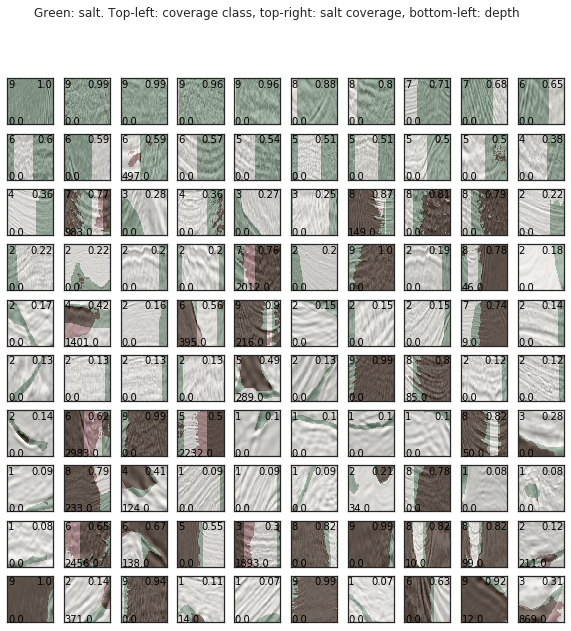

In [59]:
train_df['fp_sum'] = pd.Series([np.sum(row['false_positives']) for _, row in train_df.iterrows()], 
                                 index = train_df.index)
train_df['fn_sum'] = pd.Series([np.sum(row['false_negatives']) for _, row in train_df.iterrows()], 
                                 index = train_df.index)

plot_prediciton_and_false_positive(train_df.sort_values('fn_sum', ascending=False))

In [126]:
from metrics import *
train_df['iou'] = pd.Series([np.sum(np.logical_and(row['predict'], row['masks']))
                             / np.sum(np.logical_or(row['predict'], row['masks'])) for _, row in train_df.iterrows()], 
                                 index = train_df.index)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


In [67]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(image, cmap="gray")
    axarr[1].imshow(mask, cmap="gray")
    axarr[0].grid(False)
    axarr[1].grid(False)
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')
def plot2x2Array2(images, titles=None):
#     f, axs = plt.subplots(2,2,figsize=(15,15))
    f, axarr = plt.subplots(1, len(images),figsize=(15,15))
    for indx, im in enumerate(images):
        axarr[indx].imshow(im, cmap="gray")
        axarr[indx].grid(False)
        if titles:
            axarr[indx].set_title(titles[indx])
        
    # axarr[0].imshow(image, cmap="gray")
    # axarr[1].imshow(mask, cmap="gray")
    # axarr[0].grid(False)
    # axarr[1].grid(False)
    # axarr[0].set_title('Image')
    # axarr[1].set_title('Mask')

In [127]:
train_df.keys()

Index(['z', 'images', 'masks', 'coverage', 'coverage_class', 'predict',
       'false_positives', 'false_negatives', 'sort_val', 'fp_sum', 'fn_sum',
       'iou'],
      dtype='object')

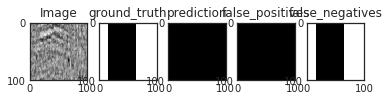

In [54]:
row = train_df.loc['33887a0ae7']
plot2x2Array2(
        images=[row.images, row.masks, row.predict, row.false_positives, row.false_negatives],
    titles=['Image', 'ground_truth', 'prediction',  'false_positives', 'false_negatives']
    )


### top 10 worst predictions
##### not taking into account vertical masks

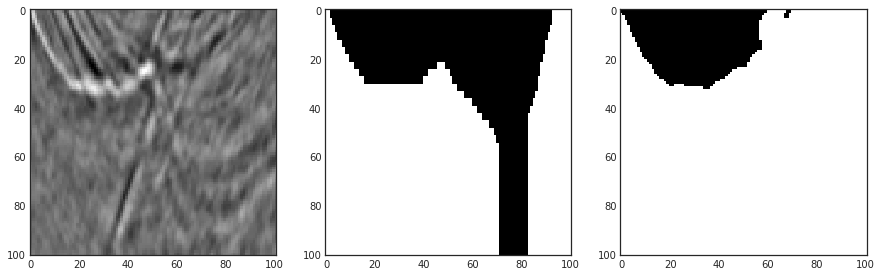

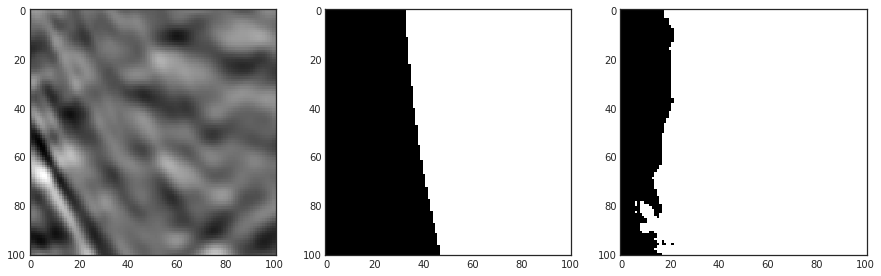

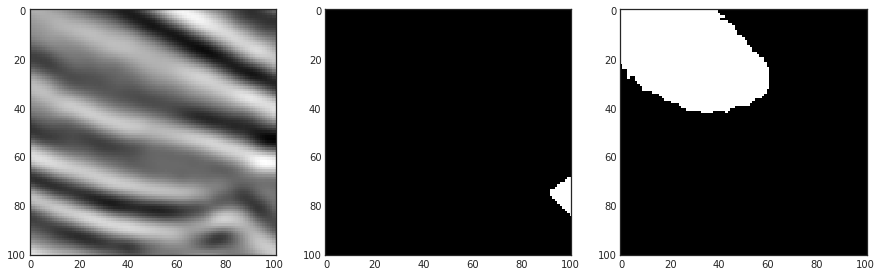

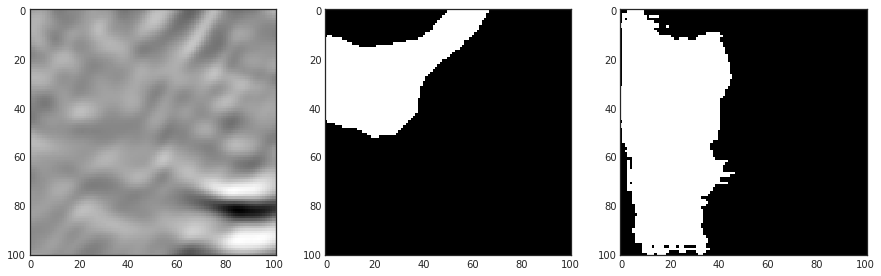

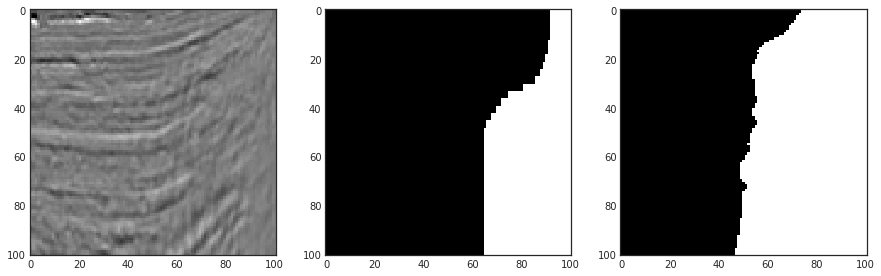

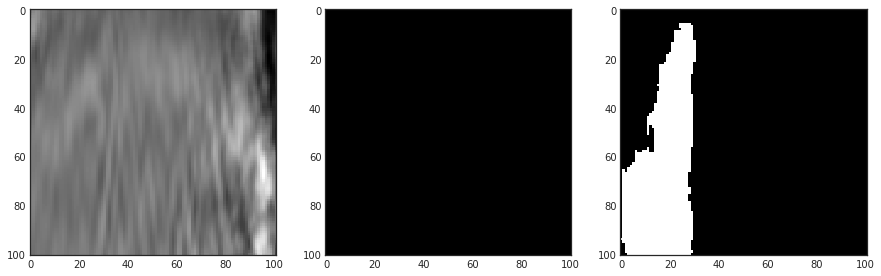

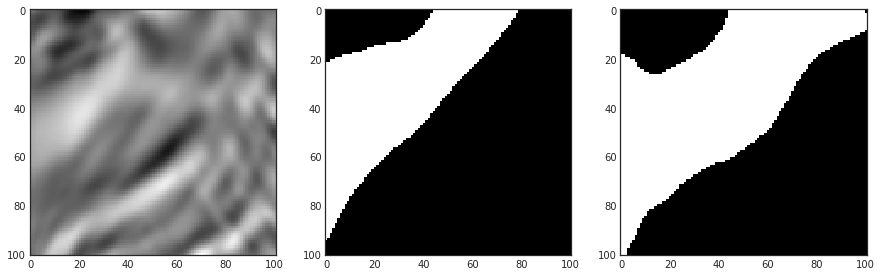

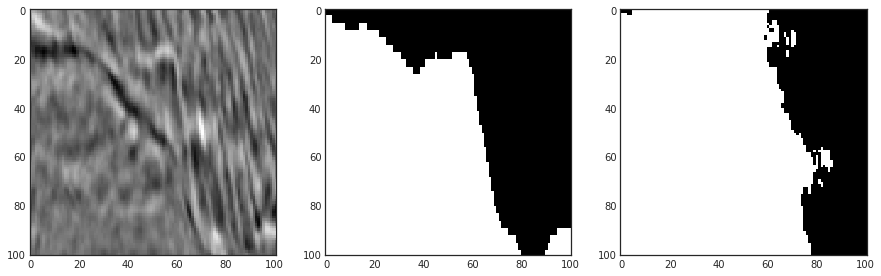

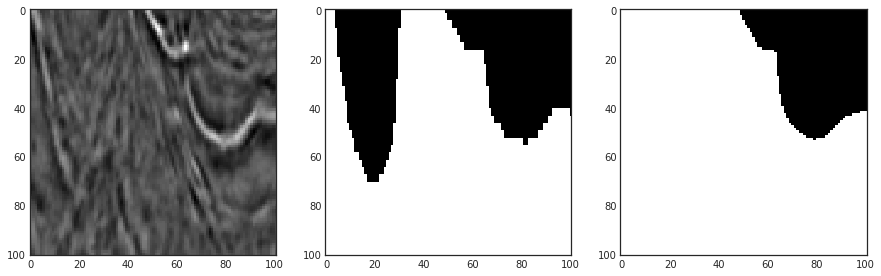

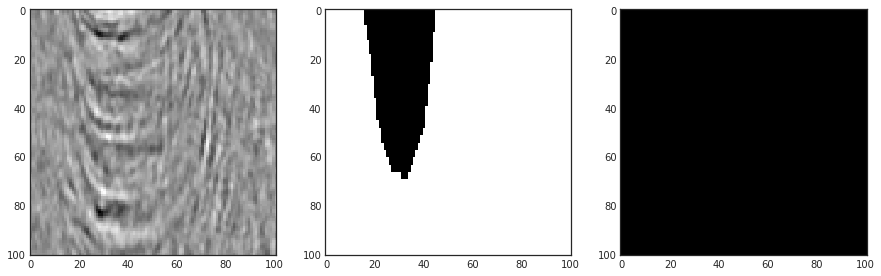

In [84]:
for _, row in (train_df_filtered.sort_values('fp_sum', ascending=False)[20:30]).iterrows():
    # print(row.false_positives.dtype)indx
    # print(row.images.dtype)
    plot2x2Array2(
        images=[row.images,
                row.masks,
                row.predict,
               ]
        ,

    )

### false positives rate per coverage class

[81513.0, 60775.0, 40682.0, 38340.0, 34141.0, 47685.0, 49036.0, 53160.0, 26170.0, 14863.0]
[0.005115676816600918, 0.009719003654601243, 0.012823280990987895, 0.016412467482210195, 0.015144021458281306, 0.01947725713165376, 0.022050365632439346, 0.03065443410968936, 0.014743877938493747, 0.0055611222069981165]


<BarContainer object of 10 artists>

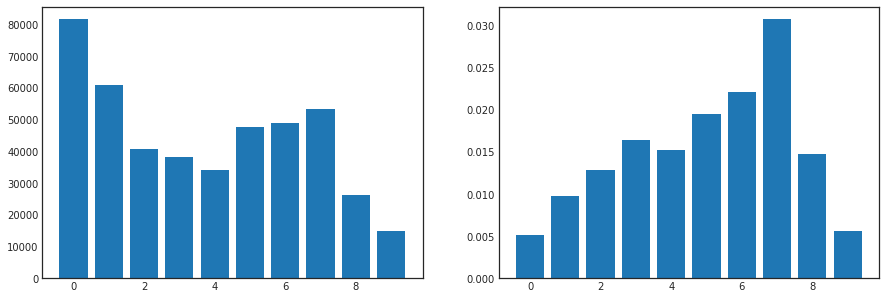

In [121]:
avg_error = []
fp_over_class = []
for cov_class in range(N_COVERAGE_CLASSES):
    selected_class = train_df[train_df['coverage_class'] == cov_class]
    number_of_examples = len(selected_class.index)
    sum_of_fp = np.sum(np.sum(selected_class['false_positives']))
    fp_over_class.append(sum_of_fp)
    avg_error.append( (sum_of_fp/number_of_examples) / (101*101) )
#     break
print(fp_over_class)
print(avg_error)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].bar(np.arange(N_COVERAGE_CLASSES),fp_over_class)
axs[1].bar(np.arange(N_COVERAGE_CLASSES),avg_error)


### false positives rate per coverage class filtered

[81513.0, 50747.0, 32536.0, 30501.0, 27512.0, 37243.0, 29435.0, 28233.0, 19207.0, 12705.0]
[0.005115676816600918, 0.008182086121587667, 0.010631637421167859, 0.013408076144825335, 0.012544141819201491, 0.01659507534911907, 0.014427507107146359, 0.018089345335232418, 0.012147449174812084, 0.004962016457256945]


<BarContainer object of 10 artists>

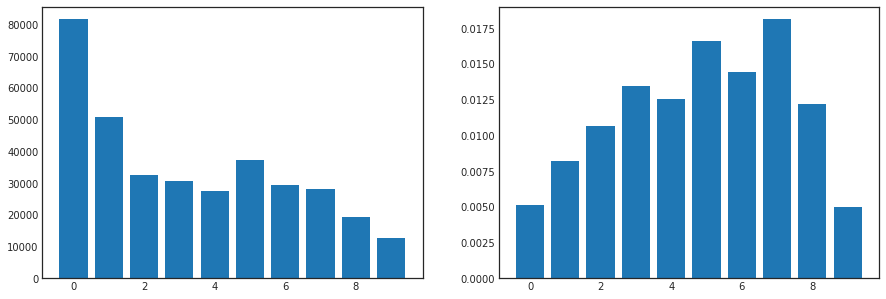

In [122]:
avg_error = []
fp_over_class = []
for cov_class in range(N_COVERAGE_CLASSES):
    selected_class = train_df_filtered[train_df_filtered['coverage_class'] == cov_class]
    number_of_examples = len(selected_class.index)
    sum_of_fp = np.sum(np.sum(selected_class['false_positives']))
    fp_over_class.append(sum_of_fp)
    avg_error.append( (sum_of_fp/number_of_examples) / (101*101) )
    avg_error.append( (sum_of_fp/number_of_examples) / (101*101) )
#     break
print(fp_over_class)
print(avg_error)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].bar(np.arange(N_COVERAGE_CLASSES),fp_over_class)
axs[1].bar(np.arange(N_COVERAGE_CLASSES),avg_error)


### false negatives rate per coverage class

[0.0, 53364.0, 66835.0, 34790.0, 33676.0, 51656.0, 52833.0, 34988.0, 47506.0, 73786.0]
[0.0, 0.008533852916892485, 0.021066908830260953, 0.014892794567190733, 0.014937760072320122, 0.02109923863673496, 0.023757789531337548, 0.020175645986264323, 0.02676433570294551, 0.027607681031121777]


<BarContainer object of 10 artists>

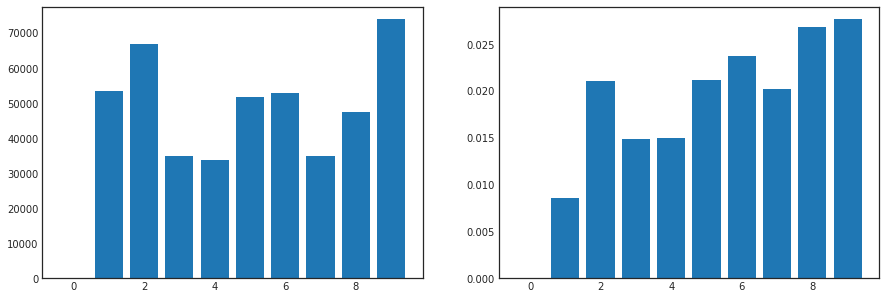

In [124]:
avg_error = []
fp_over_class = []
for cov_class in range(N_COVERAGE_CLASSES):
    selected_class = train_df[train_df['coverage_class'] == cov_class]
    number_of_examples = len(selected_class.index)
    sum_of_fp = np.sum(np.sum(selected_class['false_negatives']))
    fp_over_class.append(sum_of_fp)
    avg_error.append( (sum_of_fp/number_of_examples) / (101*101) )
#     break
print(fp_over_class)
print(avg_error)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].bar(np.arange(N_COVERAGE_CLASSES),fp_over_class)
axs[1].bar(np.arange(N_COVERAGE_CLASSES),avg_error)


### iou per coverage class

[0.0, 335.2639916805254, 253.104023452656, 206.2697918814721, 205.31404752974737, 222.1584813151251, 203.22828809571897, 159.23927241925918, 165.53371703986653, 253.06348055293785]
[0.0, 0.5469233143238588, 0.8138393037062894, 0.9007414492640703, 0.9290228395011193, 0.9256603388130212, 0.932239853650087, 0.9367016024662305, 0.9513432013785433, 0.9658911471486178]


<BarContainer object of 10 artists>

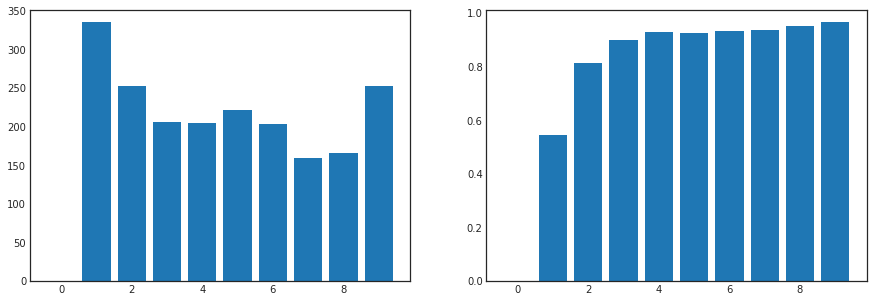

In [134]:
avg_error = []
fp_over_class = []
for cov_class in range(N_COVERAGE_CLASSES):
    selected_class = train_df[train_df['coverage_class'] == cov_class]
    number_of_examples = len(selected_class.index)
    sum_of_fp = np.sum(np.sum(selected_class['iou']) )
    fp_over_class.append(sum_of_fp)
    avg_error.append(sum_of_fp/number_of_examples)
#     break
print(fp_over_class)
print(avg_error)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].bar(np.arange(N_COVERAGE_CLASSES),fp_over_class)
axs[1].bar(np.arange(N_COVERAGE_CLASSES),avg_error)

### iou per coverage class filtered

[0.0, 334.9124091304502, 252.9055186326678, 203.15175893414224, 202.2477277620585, 209.16223870234666, 193.008275275578, 146.61226296228114, 150.45455714161898, 244.74385330329233]
[0.0, 0.5508427781750825, 0.843018395442226, 0.9109944346822522, 0.9406871058700396, 0.9507374486470302, 0.96504137637789, 0.9582500847207918, 0.9706745622039934, 0.9750751127621208]


<BarContainer object of 10 artists>

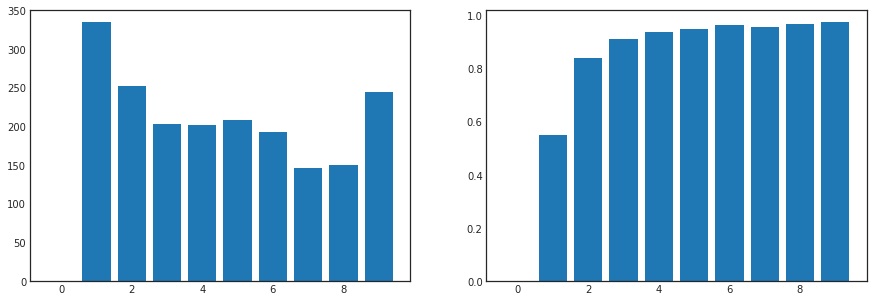

In [136]:
avg_error = []
fp_over_class = []
for cov_class in range(N_COVERAGE_CLASSES):
    selected_class = train_df_filtered[train_df_filtered['coverage_class'] == cov_class]
    number_of_examples = len(selected_class.index)
    sum_of_fp = np.sum(np.sum(selected_class['iou']) )
    fp_over_class.append(sum_of_fp)
    avg_error.append(sum_of_fp/number_of_examples)
#     break
print(fp_over_class)
print(avg_error)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].bar(np.arange(N_COVERAGE_CLASSES),fp_over_class)
axs[1].bar(np.arange(N_COVERAGE_CLASSES),avg_error)